In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/DL/fruit_data.zip" .

In [ ]:
!unzip fruit_data.zip

Archive:  fruit_data.zip
   creating: fruit_data/
   creating: fruit_data/train/
   creating: fruit_data/train/freshoranges/
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.08.09 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.08.29 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.00.23 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.59.54 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.56.02 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.50.28 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.53.33 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.52.21 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.04.51 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.10.10 AM.png  
  inf

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

import random
random.seed(0)

torch.manual_seed(40)

In [ ]:
basic_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
train_set = ImageFolder("./fruit_data/train", basic_transforms)
val_set = ImageFolder("./fruit_data/valid", basic_transforms)

In [ ]:
from torch.utils import data

train_dataloader = data.DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=16, shuffle=True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torchvision import models
from torch import nn

class VGGModel(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.vgg = models.vgg16(pretrained=True)
    self.vgg.classifier = self.vgg.classifier[:-1]
    self.vgg.classifier.append(
        nn.Linear(in_features=4096, out_features=6, bias=True)
    )

  def forward(self, x):
    return self.vgg(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VGGModel()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 254MB/s]


VGGModel(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [ ]:
from torch import optim
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model(dataloader, model, loss_fn, optimizer):
  pred_list = torch.tensor([]).to(device)
  true_list = torch.tensor([]).to(device)
  losses = []
  model.train()
  for d in tqdm(dataloader):
    inputs, labels = d
    outputs = model(inputs.to(device))
    logits = torch.argmax(outputs, dim=1)

    pred_list = torch.concatenate([pred_list, logits])
    true_list = torch.concatenate([true_list, labels.to(device)])

    loss = loss_fn(outputs, labels.to(device))
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return torch.mean(torch.tensor(losses)).item(), true_list.detach(), pred_list.detach()


def eval_model(dataloader, model, loss_fn):
  pred_list = torch.tensor([]).to(device)
  true_list = torch.tensor([]).to(device)
  losses = []
  model.eval()
  with torch.no_grad():
    for d in tqdm(dataloader):
      inputs, labels = d
      outputs = model(inputs.to(device))
      logits = torch.argmax(outputs, dim=1)

      pred_list = torch.concatenate([pred_list, logits])
      true_list = torch.concatenate([true_list, labels.to(device)])

      loss = loss_fn(outputs, labels.to(device))
      losses.append(loss.item())

  return torch.mean(torch.tensor(losses)).item(), true_list, pred_list




In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
EPOCH = 10
history = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

for i in range(EPOCH):
  print(f"Training epoch {i+1}/{EPOCH}")
  loss, true_list, pred_list = train_model(train_dataloader, model, loss_fn, optimizer)

  acc = accuracy_score(true_list.cpu().numpy(), pred_list.cpu().numpy())

  print(f"train loss : {loss}, train acc : {acc}")

  history["train_loss"].append(loss)
  history["train_acc"].append(acc)

  loss, true_list, pred_list = eval_model(val_dataloader, model, loss_fn)

  acc = accuracy_score(true_list.cpu().numpy(), pred_list.cpu().numpy())

  print(f"val loss : {loss}, val acc : {acc}")

  history["val_loss"].append(loss)
  history["val_acc"].append(acc)



Training epoch 1/10


100%|██████████| 74/74 [00:28<00:00,  2.63it/s]


train loss : 0.4021206200122833, train acc : 0.8798646362098139


100%|██████████| 21/21 [00:03<00:00,  5.84it/s]


val loss : 0.3399883508682251, val acc : 0.9148936170212766
Training epoch 2/10


100%|██████████| 74/74 [00:22<00:00,  3.30it/s]


train loss : 0.11225726455450058, train acc : 0.9653130287648054


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


val loss : 0.06900664418935776, val acc : 0.9726443768996961
Training epoch 3/10


100%|██████████| 74/74 [00:22<00:00,  3.25it/s]


train loss : 0.1141924113035202, train acc : 0.9653130287648054


100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


val loss : 0.12975086271762848, val acc : 0.9544072948328267
Training epoch 4/10


100%|██████████| 74/74 [00:23<00:00,  3.15it/s]


train loss : 0.13823996484279633, train acc : 0.9703891708967851


100%|██████████| 21/21 [00:03<00:00,  5.75it/s]


val loss : 0.12925294041633606, val acc : 0.9696048632218845
Training epoch 5/10


100%|██████████| 74/74 [00:20<00:00,  3.60it/s]


train loss : 0.04506731778383255, train acc : 0.9898477157360406


100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


val loss : 0.1951926350593567, val acc : 0.9726443768996961
Training epoch 6/10


100%|██████████| 74/74 [00:20<00:00,  3.63it/s]


train loss : 0.008083728142082691, train acc : 0.9974619289340102


100%|██████████| 21/21 [00:04<00:00,  4.63it/s]


val loss : 0.18036344647407532, val acc : 0.9665653495440729
Training epoch 7/10


100%|██████████| 74/74 [00:23<00:00,  3.17it/s]


train loss : 0.1098843663930893, train acc : 0.9670050761421319


100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


val loss : 0.13640348613262177, val acc : 0.9513677811550152
Training epoch 8/10


100%|██████████| 74/74 [00:20<00:00,  3.60it/s]


train loss : 0.15283069014549255, train acc : 0.9576988155668359


100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


val loss : 0.1368587166070938, val acc : 0.9696048632218845
Training epoch 9/10


100%|██████████| 74/74 [00:20<00:00,  3.63it/s]


train loss : 0.008576830849051476, train acc : 0.9983079526226735


100%|██████████| 21/21 [00:03<00:00,  5.79it/s]


val loss : 0.06942977756261826, val acc : 0.9817629179331308
Training epoch 10/10


100%|██████████| 74/74 [00:20<00:00,  3.54it/s]


train loss : 0.06851409375667572, train acc : 0.9805414551607445


100%|██████████| 21/21 [00:04<00:00,  4.34it/s]

val loss : 0.11572619527578354, val acc : 0.9604863221884499


Text(0.5, 1.0, 'Loss Curve')

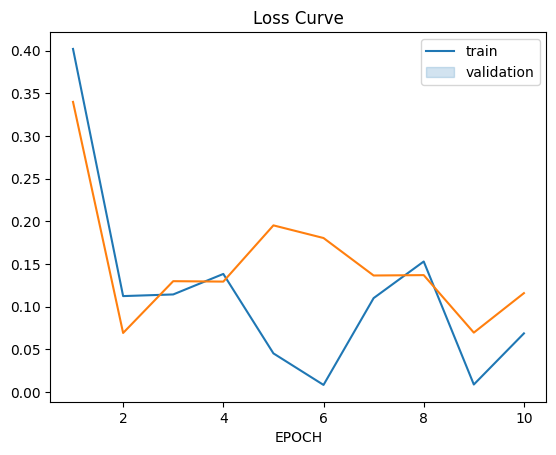

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(1,EPOCH+1), y=history['train_loss'])
sns.lineplot(x=range(1,EPOCH+1), y=history['val_loss'])
plt.legend(['train', 'validation'])
plt.xlabel("EPOCH")
plt.title("Loss Curve")

Text(0.5, 1.0, 'Accuracy')

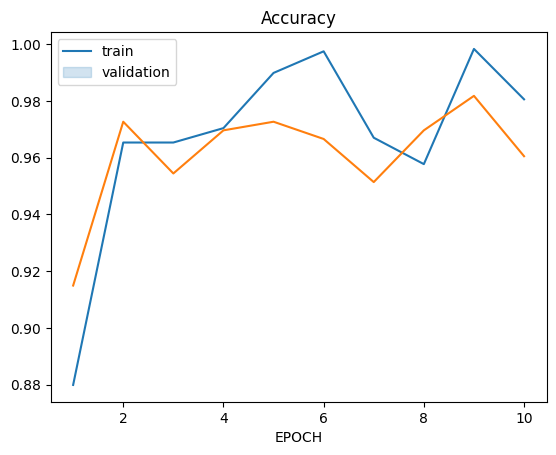

In [ ]:
sns.lineplot(x=range(1,EPOCH+1), y=history['train_acc'])
sns.lineplot(x=range(1,EPOCH+1), y=history['val_acc'])
plt.legend(['train', 'validation'])
plt.xlabel("EPOCH")
plt.title("Accuracy")

In [ ]:
print("VGG16")
print(classification_report(true_list.cpu().numpy(), pred_list.cpu().numpy()))

VGG16
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97        50
         1.0       1.00      1.00      1.00        49
         2.0       0.91      0.95      0.93        43
         3.0       0.95      0.97      0.96        74
         4.0       0.97      0.99      0.98        68
         5.0       0.95      0.87      0.91        45

    accuracy                           0.96       329
   macro avg       0.96      0.96      0.96       329
weighted avg       0.96      0.96      0.96       329

